# Sistemas _massive_ MIMO com quantizadores 1-bit

Esse relatório irá demonstrar o processo de simulação de um sistema de comunicação _massive_ MIMO na qual quantizadores de 1-bit são utilizados nas antenas. 

In [2]:
# Bibliotecas numéricas e devisualização de gráficos
import numpy as np
import matplotlib.pyplot as plt

# Bibliotecas pessoais para funções itnernas
from TransmissaoDigital.Operations import *
from TransmissaoDigital.Plots import *

Parâmetros iniciais da simulação

In [3]:
M = 100 # Número de antenas
K = 20  # Número de dispositivos

messageLength = 1000000 # Números de símbolos transmitidos por usuário



Definição do canal e do sinal transmitido

In [4]:
# Matriz de canal estimada
H_real = np.matrix(np.random.normal(0,1,size=(M,K))+1j*np.random.normal(0,1,size=(M,K)))

# Simbolos a serem transmitidos
s = np.matrix(np.random.choice([-1,1],size=(K,messageLength)) + 1j * np.random.choice([-1,1],size=(K,messageLength)))/np.sqrt(2)

## Transmissão MIMO sem quantização e estimação de canal

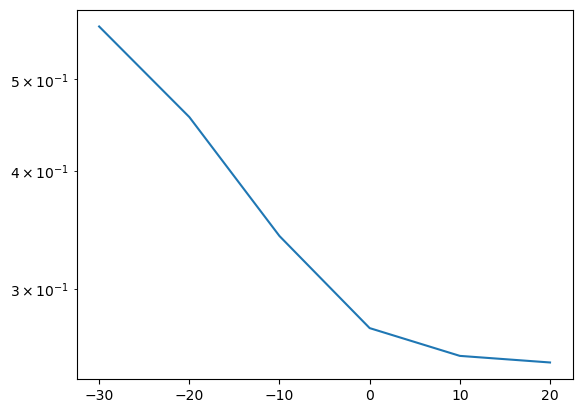

In [4]:
x,res = [],[]

for SNR in range(-30,30,10):
    
    x.append(SNR)
    
    # É feita a transmissão
    y = TransmissaoMIMO(H_real,s,SNR=SNR)

    # O sinal é estimado com base no valor recebido
    # O receptor usa o canal real
    s_est = ReceptorMRC(H_real,y)

    # O valor é decodificado (pode-se usar a própria função de quantização pra isso)
    s_quant = Quantizador(s_est)
    s_quant

    # Calcula-se o BER 
    res.append(np.sum(((s_quant.T - s)!= 0))/(s.shape[0]*s.shape[1]))
    
plt.yscale('log')
plt.plot(x,res)

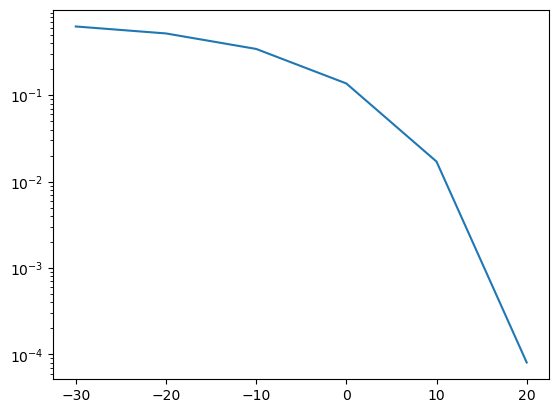

In [5]:
x,res = [],[]

for SNR in range(-30,30,10):
    
    x.append(SNR)
    
    # É feita a transmissão
    y = TransmissaoMIMO(H_real,s,SNR=SNR)

    # O sinal é estimado com base no valor recebido
    # O receptor usa o canal real
    s_est = ReceptorZF(H_real,y)

    # O valor é decodificado (pode-se usar a própria função de quantização pra isso)
    s_quant = Quantizador(s_est)
    s_quant

    # Calcula-se o BER 
    res.append(np.sum(((s_quant.T - s)!= 0))/(s.shape[0]*s.shape[1]))
    
plt.yscale('log')
plt.plot(x,res)

## Investigação atual

Tentou-se aplicar a quantização antes do processamento do sinal mas sem sucesso. Em qlqr SNR o erro era de 100%. Abaixo está a tentativa de implementar a estimação do sinal proposta no artigo para que ela utilize os receptores ZF e MRC pra ver se algum gráfico pertinente de BER sai disso. 

Verificar: 

* Implementação de 1-bit ADC MIMO do trabalho de _fulano_
* Consertar erro no estimador Bussgang
* Listar medidas necessárias para fazer alguns gráficos do aritgo

In [46]:
def EstimarCanalBussgang(H_real,tamanhoPiloto=None,SNR=20):
    """
    EstimarCanalBussgang(H_real)
    Descrição:
        Estima o canal e retorna um canal estimado
    Parametros:
        - H_real: Canal real
        - tamanhoPiloto (default=None): Quantidade de símbolos piloto 
        para transmissão. Se vazio, considera igual ao número de antenas
        definido por H_real.
        - SNR (default=20): SNR do treinamento, em dB
    Return:
        - H_est: Canal estimado
    """
    K = H_real.shape[1]
    M = H_real.shape[0]
    
    if not tamanhoPiloto:
        tamanhoPiloto = K
    
    rho_d = np.sqrt(10**(SNR/20))
    
    # Cria matriz piloto segundo especificações
    pilotos = np.fft.fft(np.eye(max(tamanhoPiloto,K)))
    Ap = np.sqrt((2/np.pi)*(1/(K*rho_d+1)))*np.eye(M*tamanhoPiloto)
    
    Phi = pilotos[0:tamanhoPiloto,0:K] 
    
    Phi_bar = np.kron(Phi,rho_d*np.eye(M))
    
    
    Phi_tilde = np.matrix(np.matmul(Ap,Phi_bar))
    #print(M*tamanhoPiloto)
    #print(Phi_tilde.shape)
    
    Y_rec = TransmissaoMIMO(H_real,pilotos,SNR=SNR)
    R_rec = Quantizador(Y_rec)
    R_rec = np.ravel(R_rec,order='F')
    
    #
    # PROBLEMA ATUAL: O calculo da matriz de autocorrelacao de R_p
    #  - Talvez tenha a solução: https://stackoverflow.com/questions/643699/how-can-i-use-numpy-correlate-to-do-autocorrelation
    #  - Verificar que R_p é o resultado vetorizado (OK-ish)
    #  - A matriz de covariancia tem q dar dimensão (2000,2000) no contexto atual (M*tamanhoPiloto)
    #
    
    print(R_rec.shape)
    Cov_R = np.correlate(R_rec,R_rec,mode='full')
    print(Cov_R.shape)
    Cov_R_inv = np.linalg.inv(Cov_R)
    print(Phi_tilde.H.shape)
    print(Cov_R_inv.shape)
    print(R_rec.shape)
    H_est = np.matmul(Cov_R_inv,R_rec)
    #print(H_est.shape)
    H_est = np.matmul(Phi_tilde.H,H_est)
    
    return H_est

In [48]:
EstimarCanalBussgang(H_real)

(2000,)
(3999,)


LinAlgError: 1-dimensional array given. Array must be at least two-dimensional